In [76]:
import numpy as np
import pandas as pd
import json
import tensorflow as tf
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi']= 100
#%pylab inline
plt.rcParams['figure.figsize'] = (10, 6)

In [5]:
with open("SRHourlyOutFlow.json") as datafile:
    data = json.load(datafile, encoding='utf-8')
dataset = pd.DataFrame(data)

dataset.set_index('dateTimeValues', inplace=True)
dataset['timeSeries'] = dataset['timeSeries'].apply(pd.to_numeric).str[0]
dataset.drop(dataset.columns[[0,1]], inplace=True, axis=1)
#dataset.drop(dataset.columns[[1, 2]])


dataset.head()

,timeSeries
dateTimeValues,
2013-12-30 00,0.216292
2013-12-30 01,0.225202
2013-12-30 02,0.232847
2013-12-30 03,0.235716
2013-12-30 04,0.246053


In [62]:
'''tf.app.flags.DEFINE_integer('model_version', 1, 'version number of the model.')
tf.app.flags.DEFINE_string('work_dir', '', 'Working directory.')
FLAGS = tf.app.flags.FLAGS'''

In [6]:
#dataset.index=pd.to_datetime(dataset.index)

#dataset.head(10)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52584 entries, 2013-12-30 00 to 2019-12-29 23
Data columns (total 1 columns):
timeSeries    52584 non-null float64
dtypes: float64(1)
memory usage: 821.6+ KB


In [7]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [8]:
def next_batch(training_data,batch_size,steps):
    
    
    # Grab a random starting point for each batch
    rand_start = np.random.randint(0,high=len(training_data)-steps)

    # Create Y data for time series in the batches
    data = np.array(train_set[rand_start:rand_start+steps+1]).reshape(1,steps+1)

    return data[:, :-1].reshape(-1, steps, 1), data[:, 1:].reshape(-1, steps, 1) 

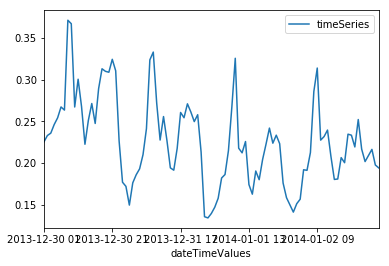

In [9]:
#train_set, test_set = split_train_test(dataset, 0.2)
#print(len(train_set), "train +", len(test_set), "test")



train_set = dataset[0:52483]
test_set= dataset[52483:52584]
train_set.head()
adg = train_set[1:100]

adg.plot()

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#train_set.shape
train_scaled = train_set.values# scaler.fit_transform(train_set)
#test_scaled = scaler.transform(test_set)


In [93]:
tf.reset_default_graph()

# Just one feature, the time series
num_inputs = 1
num_time_steps = 96
num_neurons = 200#300 #200
num_outputs = 1
learning_rate = 0.0003#0.001 #0.0005
num_train_iterations = 50000#75000




# Size of the batch of data
batch_size = 1


X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])
#train_set=train_set.reshape(-1,num_time_steps,1)

# Also play around with GRUCell
#cell = tf.contrib.rnn.OutputProjectionWrapper(
   # tf.contrib.rnn.LSTMCell(num_units=num_neurons, activation=tf.nn.relu),
    #output_size=num_outputs) 

# Also play around with GRUCell
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.GRUCell(num_units=num_neurons, activation=tf.nn.tanh),
    output_size=num_outputs) 

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32,parallel_iterations=64)
outputs.get_shape()
#states.get_shape()

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE

#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,momentum=0.5,centered=True,decay=0.9)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)



In [94]:
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(train_scaled,batch_size,num_time_steps)
        
        sess.run(train, feed_dict={X: X_batch,y:y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
            print(iteration, "\tMSE:", mse)
    
    '''
    print('Done training!')
    # Export model
    export_path_base = FLAGS.work_dir
    export_path = os.path.join(
        tf.compat.as_bytes(export_path_base),
        tf.compat.as_bytes(str(FLAGS.model_version)))
    print('Exporting trained model to', export_path)
    builder = tf.saved_model.builder.SavedModelBuilder(export_path)

    tensor_info_x = tf.saved_model.utils.build_tensor_info(X)
    tensor_info_y = tf.saved_model.utils.build_tensor_info(outputs)

    prediction_signature = (
        tf.saved_model.signature_def_utils.build_signature_def(
          inputs={'input': tensor_info_x},
          outputs={'output': tensor_info_y},
          method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME))

    legacy_init_op = tf.group(tf.tables_initializer(), name='legacy_init_op')
    builder.add_meta_graph_and_variables(
        sess, [tf.saved_model.tag_constants.SERVING],
        signature_def_map={
          'prediction':
              prediction_signature,
      },
      legacy_init_op=legacy_init_op)

    builder.save()

    print('Done exporting!')'''

    # Save Model for Later
    #saver.save(sess, "/home/infd-003/sequence_model_poc/model_saved/ex_time_series_model1.ckpt")
    saver.save(sess, "/home/ml/office/GRUCell/OutFlow/Hourly/GRUCellSRHourlyOutFlow.ckpt")
   

0 	MSE: 0.235105
100 	MSE: 0.00994948
200 	MSE: 0.00249132
300 	MSE: 0.00448763
400 	MSE: 0.00267819
500 	MSE: 0.00131551
600 	MSE: 0.00150647
700 	MSE: 0.00295533
800 	MSE: 0.00510784
900 	MSE: 0.00192124
1000 	MSE: 0.00091104
1100 	MSE: 0.00176943
1200 	MSE: 0.000932292
1300 	MSE: 0.00277263
1400 	MSE: 0.00122418
1500 	MSE: 0.00339516
1600 	MSE: 0.00195387
1700 	MSE: 0.00158127
1800 	MSE: 0.00144876
1900 	MSE: 0.00124532
2000 	MSE: 0.000883911
2100 	MSE: 0.00161924
2200 	MSE: 0.00247796
2300 	MSE: 0.000962018
2400 	MSE: 0.00119302
2500 	MSE: 0.00115497
2600 	MSE: 0.00137219
2700 	MSE: 0.00166254
2800 	MSE: 0.00289494
2900 	MSE: 0.00258407
3000 	MSE: 0.000898433
3100 	MSE: 0.00126302
3200 	MSE: 0.00389083
3300 	MSE: 0.00121491
3400 	MSE: 0.00163507
3500 	MSE: 0.00183642
3600 	MSE: 0.00130518
3700 	MSE: 0.00116072
3800 	MSE: 0.00106134
3900 	MSE: 0.00247048
4000 	MSE: 0.00140854
4100 	MSE: 0.0017975
4200 	MSE: 0.00119838
4300 	MSE: 0.00181598
4400 	MSE: 0.00176709
4500 	MSE: 0.0011682


35600 	MSE: 0.00150612
35700 	MSE: 0.000547429
35800 	MSE: 0.00043273
35900 	MSE: 0.00130115
36000 	MSE: 0.00182072
36100 	MSE: 0.000658913
36200 	MSE: 0.000860387
36300 	MSE: 0.00143371
36400 	MSE: 0.000475149
36500 	MSE: 0.000839168
36600 	MSE: 0.00174688
36700 	MSE: 0.000913155
36800 	MSE: 0.000853041
36900 	MSE: 0.00116532
37000 	MSE: 0.000731631
37100 	MSE: 0.00072996
37200 	MSE: 0.00133178
37300 	MSE: 0.0010384
37400 	MSE: 0.000737379
37500 	MSE: 0.000434419
37600 	MSE: 0.000782254
37700 	MSE: 0.00207716
37800 	MSE: 0.000712224
37900 	MSE: 0.000534739
38000 	MSE: 0.00088294
38100 	MSE: 0.000782403
38200 	MSE: 0.000596953
38300 	MSE: 0.000704888
38400 	MSE: 0.000962354
38500 	MSE: 0.000595156
38600 	MSE: 0.0014271
38700 	MSE: 0.000487276
38800 	MSE: 0.00221641
38900 	MSE: 0.00110324
39000 	MSE: 0.000839607
39100 	MSE: 0.000902847
39200 	MSE: 0.00102818
39300 	MSE: 0.000684795
39400 	MSE: 0.00102539
39500 	MSE: 0.00131423
39600 	MSE: 0.000484606
39700 	MSE: 0.00229643
39800 	MSE: 0

In [95]:
with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    #saver.restore(sess, "/home/infd-003/sequence_model_poc/model_saved/ex_time_series_model1.ckpt")
    saver.restore(sess, "/home/ml/office/GRUCell/OutFlow/Hourly/GRUCellSRHourlyOutFlow.ckpt")

    # Create a numpy array for your genreative seed from the last 12 months of the 
    # training set data. Hint: Just use tail(12) and then pass it to an np.array
    train_seed = list(train_scaled[-num_time_steps:])
    
    ## Now create a for loop that 
    for iteration in range(100):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(-1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        train_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from /home/ml/office/GRUCell/OutFlow/Hourly/GRUCellSRHourlyOutFlow.ckpt


In [96]:
len(train_seed[num_time_steps:])

100

In [97]:
results = np.array(train_seed[num_time_steps:]).reshape(100,1)
#results = scaler.inverse_transform(np.array(train_seed[num_time_steps:]).reshape(100,1))

In [98]:
new_test_set = test_set.head(100)


In [99]:
new_test_set['predicted'] = results

/home/ml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [52]:
#print(new_test_set)

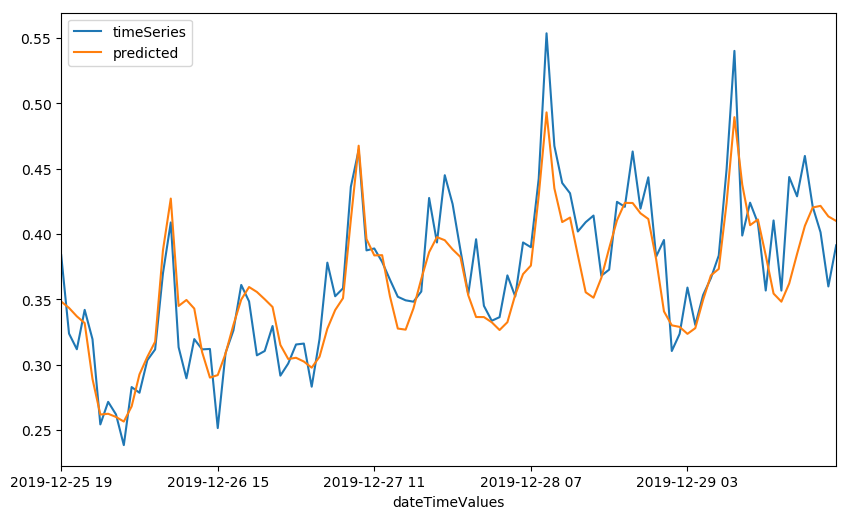

In [100]:
new_test_set.plot()